# Analysis of Dynamometer Card Tables

This notebook contains codes and functions to run queries to analyze and understand data present in he dynocard dataset:

**DEV DB:**
- Database Name: oasis-dev
- Schema Name : xspoc
- Table Name: card

**Main DB:**
- Database Name: oasis-data
- Schema Name : xspoc_dbo
- Table Name: tblCardData

*Note: For NodeID 'Spratley 5494 14-13 15T' data has not been transferred yet. Once issues are resolved it will be done*


In [1]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [12]:
import pandas as pd
import numpy as np
import struct
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.wkb import loads

# Project Library
from library.dbconnection import PostgresRDS
from library.sql_functions import run_query
from library.card_functions import Cleaning

In [3]:
"""
Dyna Functions
Note: Once Testing done will be moved to the cardFunctions library
"""
# Plotting
"""
Plotting
"""
def dyna_plot(poly, name, fill=True, color='k', set_axis=None, save=None, show=True):
    """
    Plots the card
    """
    xy = np.asarray(poly.exterior.coords)
    pos_clean, load_clean = xy[:,0], xy[:,1]

    fig_clean, ax_clean = plt.subplots()

    if fill:
        ax_clean.fill(pos_clean, load_clean, facecolor=color, alpha=1)
    else:
        ax_clean.plot(pos_clean, load_clean, c=color, alpha=1)

    if set_axis:
        ax_clean.set_ylim(set_axis)

#     plt.axis('off')
    fig_clean.set_size_inches(12, 8)
    fig_clean.patch.set_facecolor('w')
    plt.title(name)
    
    if save:
        save_name = os.path.join(save, name + ".png")
        plt.savefig(save_name, dpi=50, bbox_inches='tight')
    
    if show:
        plt.show()

    plt.close()

## DataSet Info

In [4]:
#Setup
database = 'oasis-dev'

In [8]:
query = """SELECT DISTINCT "NodeID" from xspoc.card ORDER BY "NodeID";"""

cols_query = """
SELECT attname            AS col
     , atttypid::regtype  AS datatype
       -- more attributes?
FROM   pg_attribute
WHERE  attrelid = 'xspoc.card'::regclass  -- table name, optionally schema-qualified
AND    attnum > 0
AND    NOT attisdropped
ORDER  BY attnum;
"""
with PostgresRDS(db=database) as engine:
    well_list = pd.read_sql(query, engine)
    col_list = pd.read_sql(cols_query, engine)

Connected to oasis-dev DataBase
Connection Closed


In [9]:
print("List of Columns")
display(col_list)

print("\nList of Wells")
display(well_list)

List of Columns


,col,datatype
0,NodeID,text
1,Date,timestamp without time zone
2,pocdowncard,geometry
3,surfcard,geometry
4,downcard,geometry
5,PredictedCardB,geometry
6,TorquePlotMinEnergyB,geometry
7,TorquePlotMinTorqueB,geometry
8,TorquePlotCurrentB,geometry
9,PermissibleLoadUpB,geometry



List of Wells


,NodeID
0,Bonner 9-12H
1,Bonner 9X-12HA
2,Bonner 9X-12HB
3,Cade 12-19HA
4,Cade 12-19HB
5,Cade 12X-19H
6,Cook 12-13 6B
7,Cook 12-13 7T
8,Cook 12-13 9T
9,Cook 41-12 11T


## Well Specific

- Queries for a single well.
- Specify the card columns (geometry dtype) in col_list if those cards are being queried.
- Add or delete columns

In [13]:
well_name = 'Helling Trust 44-22 5B'  # Select WellName
card_cols = ['pocdowncard', 'surfcard', "PredictedCardB"]  # Specify the dyna column names

# Can play around with the columns in the query
query = """
SELECT 
"NodeID",
"Date",
pocdowncard,
surfcard,
"PredictedCardB",
"SPM",
"Fillage",
"FillBasePct",
"CauseID"
FROM xspoc.card
WHERE "NodeID" = '{}'
ORDER BY "NodeID" , "Date";
""".format(well_name)

with PostgresRDS(db=database) as engine:
    well_data = run_query(query, engine)

for c in card_cols:
    well_data.loc[:, c] = well_data.loc[:, c].apply(lambda x: loads(x, hex=True))
    
display(well_data.head())

Connected to oasis-dev DataBase
Connection Closed


,NodeID,Date,pocdowncard,surfcard,PredictedCardB,SPM,Fillage,FillBasePct,CauseID
0,Helling Trust 44-22 5B,2019-03-19 00:49:45,"POLYGON ((4.079999923706055 -7744, 12.27000045...","POLYGON ((0.6200000047683716 20540, 1.25 20214...","POLYGON ((0 21268.8359375, 0 21268.8359375, 0....",1.1,75.8,45,99
1,Helling Trust 44-22 5B,2019-03-19 02:34:22,"POLYGON ((4.639999866485596 -7854, 13.18999958...","POLYGON ((0.6200000047683716 20143, 1.25 20054...","POLYGON ((0 21418.443359375, 0 21418.443359375...",1.1,86.6,45,99
2,Helling Trust 44-22 5B,2019-03-19 04:40:26,"POLYGON ((3.900000095367432 -7646, 10.40999984...","POLYGON ((0.3899999856948853 21428, 0.77999997...","POLYGON ((0 23747.9140625, 0 23747.9140625, 0....",2.9,98.2,45,99
3,Helling Trust 44-22 5B,2019-03-19 06:42:07,"POLYGON ((5.510000228881836 -7611, 13.06000041...","POLYGON ((0.3600000143051147 21547, 0.79000002...","POLYGON ((0 24334.400390625, 0 24334.400390625...",2.9,98.8,45,99
4,Helling Trust 44-22 5B,2019-03-19 08:44:33,"POLYGON ((5.920000076293945 -6596, 19.96999931...","POLYGON ((0.6399999856948853 23025, 1.20000004...","POLYGON ((0 22157.5390625, 0 22157.5390625, 0....",1.5,87.5,45,99


NodeID                                       Helling Trust 44-22 5B
Date                                            2019-05-14 12:58:20
pocdowncard       POLYGON ((3.410000085830688 -8053, 11.60000038...
surfcard          POLYGON ((0.3700000047683716 21547, 0.83999997...
PredictedCardB    POLYGON ((0 23654.431640625, 0 23654.431640625...
SPM                                                             2.9
Fillage                                                        95.3
FillBasePct                                                      45
CauseID                                                         107
Name: 112, dtype: object


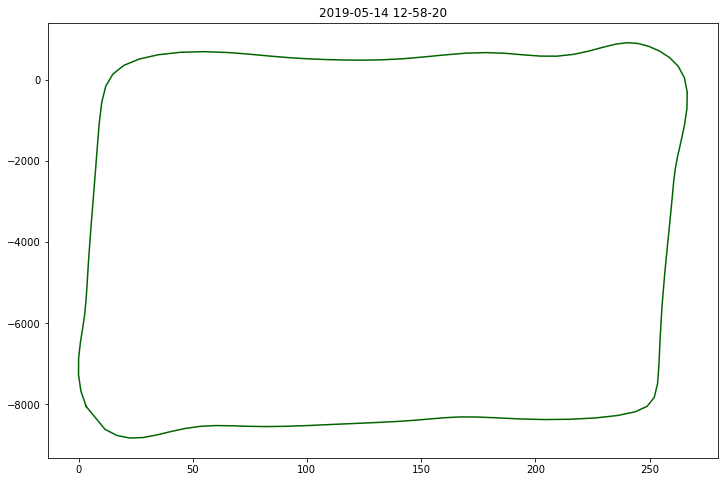

In [32]:
"""
Test the dyna_plot function
"""
index = 112
card_col = 'pocdowncard'  # select the geometry to plot
well, date, card = well_data.loc[index, ['NodeID', 'Date', card_col]]

print(well_data.loc[112])

name = date.strftime('%Y-%m-%d %H-%M-%S')
dyna_plot(card, name, fill=False, color='DARKGREEN', set_axis=None, save=None, show=True)

In [33]:
"""
Save
"""

save_path = r"/path"
card_col = 'pocdowncard'  # Select the geometry column

for i in well_data.index[0:10]:
    card, well, date = well_data.loc[i, [card_col, 'NodeID', 'Date']]
    date = pd.to_datetime(str(date))
    name = date.strftime('%Y-%m-%d %H-%M-%S')
    
    dyna_plot(card, name, fill=False, color='DARKGREEN', set_axis=None, save=save_path, show=None) 


## Query a list of wells

In [29]:
%%time
# Add wells to the list
well_list = [
    'Bonner 9-12H',
    'Bonner 9X-12HA',
    'Bonner 9X-12HB'
]

card_cols = ['pocdowncard', 'surfcard']

# Modify the query to get reqd columns
query = """
select 
"NodeID",
"Date",
pocdowncard,
surfcard,
"StrokeLength" 
from xspoc.card
where "NodeID" in {}
order by "NodeID", "Date"
""".format(tuple(well_list))

with PostgresRDS(db=database) as engine:
    data = run_query(query, engine)

for c in card_cols:
    data.loc[:, c] = data.loc[:, c].apply(lambda x: loads(x, hex=True))
    
display(data.head())

,NodeID,Date,pocdowncard,surfcard,StrokeLength
0,Bonner 9-12H,2019-01-22 13:30:13,"POLYGON ((10.10000038146973 -8889, 25.12000083...","POLYGON ((0.6100000143051147 22700, 1.23000001...",306
1,Bonner 9-12H,2019-03-19 00:51:53,"POLYGON ((6.53000020980835 -8826, 21.870000839...","POLYGON ((0.6100000143051147 22578, 1.23000001...",306
2,Bonner 9-12H,2019-03-19 02:41:29,"POLYGON ((10.06999969482422 -8892, 22.12999916...","POLYGON ((0.6100000143051147 22700, 1.23000001...",306
3,Bonner 9-12H,2019-03-19 04:57:34,"POLYGON ((4.639999866485596 -9044, 17.45000076...","POLYGON ((0.6100000143051147 22116, 1.23000001...",306
4,Bonner 9-12H,2019-03-19 06:41:44,"POLYGON ((6.300000190734863 -8971, 15.34000015...","POLYGON ((0.6100000143051147 21344, 1.23000001...",306


Wells Present


['Bonner 9-12H', 'Bonner 9X-12HA', 'Bonner 9X-12HB']

Wall time: 28.9 ms


In [28]:
data.groupby("NodeID").agg({"Date":['min', 'max', 'count']})

Date                          
                               min                 max count
NodeID                                                      
Bonner 9-12H   2019-01-22 13:30:13 2020-05-25 19:49:35  2544
Bonner 9X-12HA 2019-03-19 01:30:10 2020-05-26 06:53:43  3000
Bonner 9X-12HB 2019-03-19 00:33:33 2020-04-10 04:31:11  3957

### Unused Codes and Writeups

`
**Note:**
While specifying card based columns (bytea). Query the column as follows

```
encode("tblCardData"."ActualCardCol", 'hex') as <specifyanewname>
# eg:
encode("tblCardData"."DownholeCardB", 'hex') as downcard
```

In the variable `card_cols`, have a list of these card columns being used. For eg.
```
# Say we are QUerying 'DownholeCardB' and 'SurfaceCardB', query will look something like this

encode("tblCardData"."DownholeCardB", 'hex') as downcard,
encode("tblCardData"."SurfaceCardB", 'hex') as surfcard,

# In the python scipt
card_cols = ['downcard', 'surfcard']
```

In [ ]:
# # Writing Pos and Load Values to n excel file
# surface_card = pd.DataFrame(np.asarray(test_surf.exterior.coords), columns=['Position', 'Load'])
# down_card = pd.DataFrame(np.asarray(test_down.exterior.coords), columns=['Position', 'Load'])

# with pd.ExcelWriter("dyna_values.xlsx") as writer:
#     surface_card.to_excel(writer, sheet_name='Surface Card')
#     down_card.to_excel(writer, sheet_name='Downhole Card')

In [ ]:
# %%time
# # Some Exploratory Queries

# cols_query = """
# SELECT attname            AS col
#      , atttypid::regtype  AS datatype
#        -- more attributes?
# FROM   pg_attribute
# WHERE  attrelid = 'xspoc_dbo."tblCardData"'::regclass  -- table name, optionally schema-qualified
# AND    attnum > 0
# AND    NOT attisdropped
# ORDER  BY attnum;
# """

# well_query = """
# SELECT DISTINCT("NodeID")
# FROM xspoc_dbo."tblCardData"
# ORDER BY "NodeID"
# """

# with PostgresRDS(db='oasis-data') as engine:
#     col_list_full = run_query(cols_query, engine)  # Profiling: 1s 680ms -- Will be longer in jupyter
#     well_list_full = run_query(well_query, engine)  # Profiling: 1m 10s -- Longer in jupyte